In [1]:
from __future__ import print_function

import pandas as pd
import numpy as np
import json
import difflib
import pprint
from sklearn.utils import resample

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
customFig = (10,8)


In [2]:
df = pd.read_csv('data/nyc_inspection_results.csv')

In [3]:
df.columns = map(str.lower, df.columns)

In [4]:
df.columns = [x.strip().replace(' ', '_') for x in df.columns]

In [5]:
df['zipcode'] = df.zipcode.astype(str)

In [6]:
df['zipcode'] = df['zipcode'].str.slice(0,5)

In [7]:
df['address'] = df.building + ' ' + df.street + ' ' + df.boro + ' ' + df.zipcode

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399918 entries, 0 to 399917
Data columns (total 19 columns):
camis                    399918 non-null int64
dba                      399559 non-null object
boro                     399918 non-null object
building                 399809 non-null object
street                   399909 non-null object
zipcode                  399918 non-null object
phone                    399913 non-null object
cuisine_description      399918 non-null object
inspection_date          399918 non-null object
action                   398783 non-null object
violation_code           393414 non-null object
violation_description    392939 non-null object
critical_flag            399918 non-null object
score                    376704 non-null float64
grade                    195413 non-null object
grade_date               192820 non-null object
record_date              399918 non-null object
inspection_type          398783 non-null object
address                  

In [9]:
df['inspection_date'] = pd.to_datetime(df.inspection_date)
df['grade_date'] = pd.to_datetime(df.grade_date)
df['record_date'] = pd.to_datetime(df.record_date)

In [10]:
df['inspection_date'].max()

Timestamp('2017-08-26 00:00:00')

In [11]:
df['inspection_date'].min()

Timestamp('1900-01-01 00:00:00')

In [12]:
testDF = df.loc[df.groupby(['dba','address'])['inspection_date'].idxmax()]

In [13]:
testDF.shape

(25985, 19)

In [14]:
df[(df.dba == '#1 SABOR LATINO RESTAURANT') & (df.inspection_date == '2017-03-16')]

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,address
270497,41336841,#1 SABOR LATINO RESTAURANT,BRONX,4120,WHITE PLAINS ROAD,10466,7186532222,"Latin (Cuban, Dominican, Puerto Rican, South &...",2017-03-16,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,Not Critical,11.0,A,2017-03-16,2017-08-28,Cycle Inspection / Initial Inspection,4120 WHITE PLAINS ROAD BRONX 10466
284675,41336841,#1 SABOR LATINO RESTAURANT,BRONX,4120,WHITE PLAINS ROAD,10466,7186532222,"Latin (Cuban, Dominican, Puerto Rican, South &...",2017-03-16,Violations were cited in the following area(s).,04L,Evidence of mice or live mice present in facil...,Critical,11.0,A,2017-03-16,2017-08-28,Cycle Inspection / Initial Inspection,4120 WHITE PLAINS ROAD BRONX 10466


In [15]:
testDF['inspection_date'] = testDF.inspection_date.astype(str)

In [16]:
# create a dictionary of the restaurant name and the inspection date
l = testDF.reset_index()[['dba','inspection_date']].values.tolist()
l[:6]

[['#1 Chinese Restaurant', '2016-09-30'],
 ['#1 GARDEN CHINESE', '2017-08-23'],
 ['#1 Natural Juice Bar', '2017-08-17'],
 ['#1 SABOR LATINO RESTAURANT', '2017-03-16'],
 ['$1 PIZZA', '2017-05-22'],
 ['$1 PIZZA $2 BEER', '2017-08-23']]

In [17]:
len(l)

25985

In [18]:
testDF.shape

(25985, 19)

In [20]:
def date_max(l,df):
    maxDF = pd.DataFrame()
    
    for val in l:
        ndf = df[(df.dba == val[0]) & (df.inspection_date == val[1])]
        maxDF = maxDF.append(ndf)
    return maxDF
        

In [21]:
dateDF = date_max(l,df)

In [22]:
dateDF.shape

(72480, 19)

In [23]:
dateDF.to_pickle('data/date.pkl')

In [24]:
dateDF.inspection_date.max()

Timestamp('2017-08-26 00:00:00')

In [25]:
dateDF.inspection_date.min()

Timestamp('1900-01-01 00:00:00')

In [26]:
#dateDF.to_csv('date.csv')

In [27]:
dateDF.head()

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,address
114442,50050805,#1 Chinese Restaurant,MANHATTAN,825,W 181ST ST,10033,9173258805,Chinese,2016-09-30,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Critical,13.0,A,2016-09-30,2017-08-28,Pre-permit (Operational) / Initial Inspection,825 W 181ST ST MANHATTAN 10033
171822,50050805,#1 Chinese Restaurant,MANHATTAN,825,W 181ST ST,10033,9173258805,Chinese,2016-09-30,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rins...",Critical,13.0,A,2016-09-30,2017-08-28,Pre-permit (Operational) / Initial Inspection,825 W 181ST ST MANHATTAN 10033
270114,50050805,#1 Chinese Restaurant,MANHATTAN,825,W 181ST ST,10033,9173258805,Chinese,2016-09-30,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,13.0,A,2016-09-30,2017-08-28,Pre-permit (Operational) / Initial Inspection,825 W 181ST ST MANHATTAN 10033
147868,41568346,#1 GARDEN CHINESE,BROOKLYN,221,PROSPECT PARK WEST,11215,7188321795,Chinese,2017-08-23,Violations were cited in the following area(s).,06A,Personal cleanliness inadequate. Outer garment...,Critical,12.0,A,2017-08-23,2017-08-28,Cycle Inspection / Initial Inspection,221 PROSPECT PARK WEST BROOKLYN 11215
350094,41568346,#1 GARDEN CHINESE,BROOKLYN,221,PROSPECT PARK WEST,11215,7188321795,Chinese,2017-08-23,Violations were cited in the following area(s).,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,12.0,A,2017-08-23,2017-08-28,Cycle Inspection / Initial Inspection,221 PROSPECT PARK WEST BROOKLYN 11215


In [28]:
dateDF['key'] = dateDF.dba + '---' + dateDF.address

In [29]:
from collections import defaultdict

In [30]:
def violation_dict(df):
    d = defaultdict(list)
    i=0
    for i in range(len(df)):
        value = df['violation_code'].iloc[i]
        name = df['key'].iloc[i]
        if name not in d:
            d[name] = [value]   
        else:
            d[name].append(value)
    return d   

In [31]:
vD = violation_dict(dateDF)

In [32]:
vDF = pd.DataFrame(columns=('key','violations'))

for k,v in vD.items():
    vDF = vDF.append({'key':k,'violations':v},ignore_index=True)
    

In [33]:
vDF.shape

(25985, 2)

In [34]:
def crit_dict(df):
    d = defaultdict(list)
    i=0
    for i in range(len(df)):
        value = df['critical_flag'].iloc[i]
        name = df['key'].iloc[i]
        if name not in d:
            d[name] = [value]   
        else:
            d[name].append(value)
    return d   

In [35]:
cD = crit_dict(dateDF)

In [36]:
cDF = pd.DataFrame(columns=('key2','critical'))

for k,v in cD.items():
    cDF = cDF.append({'key2':k,'critical':v},ignore_index=True)

In [37]:
cDF.shape

(25985, 2)

In [38]:
aggDF = vDF.merge(cDF,left_on='key',right_on='key2')

In [39]:
aggDF.shape

(25985, 4)

In [40]:
aggDF.head()

,key,violations,key2,critical
0,#1 Chinese Restaurant---825 W 181ST ST MANHATT...,"[06C, 06D, 10F]",#1 Chinese Restaurant---825 W 181ST ST MANHATT...,"[Critical, Critical, Not Critical]"
1,#1 GARDEN CHINESE---221 PROSPECT PARK WEST BRO...,"[06A, 02G]",#1 GARDEN CHINESE---221 PROSPECT PARK WEST BRO...,"[Critical, Critical]"
2,#1 Natural Juice Bar---685 SENECA AVE QUEENS 1...,"[08A, 04L]",#1 Natural Juice Bar---685 SENECA AVE QUEENS 1...,"[Not Critical, Critical]"
3,#1 SABOR LATINO RESTAURANT---4120 WHITE PLAINS...,"[08A, 04L]",#1 SABOR LATINO RESTAURANT---4120 WHITE PLAINS...,"[Not Critical, Critical]"
4,$1 PIZZA---1276 FULTON ST BROOKLYN 11216,"[10H, 06E]",$1 PIZZA---1276 FULTON ST BROOKLYN 11216,"[Not Critical, Critical]"


In [41]:
aggDF.drop('key2',inplace=True,axis=1)

In [42]:
aggDF['critical'] = aggDF['critical'].apply(lambda x: ', '.join(x))

In [43]:
aggDF['violations'] = aggDF['violations'].apply(lambda x: ', '.join(str(v) for v in x))

In [44]:
aggDF.to_pickle('data/aggregated.pkl')

In [45]:
testDF['key'] = testDF.dba + '---' + testDF.address

In [46]:
cleanDF = aggDF.merge(testDF,how='left',on='key')

In [47]:
cleanDF.shape

(25985, 22)

In [48]:
cleanDF.columns.tolist()

['key',
 'violations',
 'critical',
 'camis',
 'dba',
 'boro',
 'building',
 'street',
 'zipcode',
 'phone',
 'cuisine_description',
 'inspection_date',
 'action',
 'violation_code',
 'violation_description',
 'critical_flag',
 'score',
 'grade',
 'grade_date',
 'record_date',
 'inspection_type',
 'address']

In [49]:
cleanDF.inspection_date.max()

'2017-08-26'

In [50]:
# start_date = '01/01/2014'
# end_date = '08/27/2017'
# mask = (df['inspection_date'] >= start_date) & (df['inspection_date'] <= end_date)

In [51]:
df = cleanDF.copy()

In [52]:
df.shape

(25985, 22)

In [53]:
df.violation_code.isnull().sum()

1098

In [54]:
df.dropna(subset=['violation_code'],axis=0,inplace=True)

In [55]:
df.head()

,key,violations,critical,camis,dba,boro,building,street,zipcode,phone,...,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,address
0,#1 Chinese Restaurant---825 W 181ST ST MANHATT...,"06C, 06D, 10F","Critical, Critical, Not Critical",50050805,#1 Chinese Restaurant,MANHATTAN,825,W 181ST ST,10033,9173258805,...,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Critical,13.0,A,2016-09-30,2017-08-28,Pre-permit (Operational) / Initial Inspection,825 W 181ST ST MANHATTAN 10033
1,#1 GARDEN CHINESE---221 PROSPECT PARK WEST BRO...,"06A, 02G","Critical, Critical",41568346,#1 GARDEN CHINESE,BROOKLYN,221,PROSPECT PARK WEST,11215,7188321795,...,Violations were cited in the following area(s).,06A,Personal cleanliness inadequate. Outer garment...,Critical,12.0,A,2017-08-23,2017-08-28,Cycle Inspection / Initial Inspection,221 PROSPECT PARK WEST BROOKLYN 11215
2,#1 Natural Juice Bar---685 SENECA AVE QUEENS 1...,"08A, 04L","Not Critical, Critical",50051964,#1 Natural Juice Bar,QUEENS,685,SENECA AVE,11385,3479565161,...,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,Not Critical,10.0,A,2017-08-17,2017-08-28,Cycle Inspection / Initial Inspection,685 SENECA AVE QUEENS 11385
3,#1 SABOR LATINO RESTAURANT---4120 WHITE PLAINS...,"08A, 04L","Not Critical, Critical",41336841,#1 SABOR LATINO RESTAURANT,BRONX,4120,WHITE PLAINS ROAD,10466,7186532222,...,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,Not Critical,11.0,A,2017-03-16,2017-08-28,Cycle Inspection / Initial Inspection,4120 WHITE PLAINS ROAD BRONX 10466
4,$1 PIZZA---1276 FULTON ST BROOKLYN 11216,"10H, 06E","Not Critical, Critical",50061194,$1 PIZZA,BROOKLYN,1276,FULTON ST,11216,7186384685,...,Violations were cited in the following area(s).,10H,Proper sanitization not provided for utensil w...,Not Critical,10.0,A,2017-05-22,2017-08-28,Pre-permit (Operational) / Re-inspection,1276 FULTON ST BROOKLYN 11216


In [56]:
vermin_codes = ['04K','04L','04M','04N','08A']
contamination_codes = ['04H','06B','06C','06D','08C']
facility_codes = ['10A','10B','10D','10E','10F','10H','15L','22A','22C']
food_handling_codes = ['03A','03C','09A','09B','09C']
hygiene_codes = ['04D','04F','06A','06E','06F','08B','10I']
regulatory_codes = ['04A','16B','20D','20F']
temperature_codes = ['02B','02G','02H','05F']

In [57]:
vDict = {'04K':'vermin','04L':'vermin','04M':'vermin','04N':'vermin','08A':'vermin',
'04H':'contamination','06B':'contamination','06C':'contamination','06D':'contamination',
'08C':'contamination','10A':'facility','10B':'facility','10D':'facility','10E':'facility',
'10F':'facility','10H':'facility','15L':'facility','22A':'facility','22C':'facility',
'03A':'food_handling','03C':'food_handling','09A':'food_handling','09B':'food_handling',
'09C':'food_handling','04D':'hygiene','04F':'hygiene','06A':'hygiene','06E':'hygiene',
'06F':'hygiene','08B':'hygiene','10I':'hygiene','04A':'regulatory','16B':'regulatory',
'20D':'regulatory','20F':'regulatory','02B':'temperature','02G':'temperature','02H':'temperature',
'05F':'temperature'}

In [58]:
def violations(row,d):
    s = ''
    for word in row['violations'].split(', '):
        for k,v in d.items():
            if word == k:
                s += v+', '
    return s.rstrip(', ')
    

In [59]:
df['new_violations'] = df.apply(lambda x: violations(x,vDict),axis=1)

In [60]:
df.head()

,key,violations,critical,camis,dba,boro,building,street,zipcode,phone,...,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,address,new_violations
0,#1 Chinese Restaurant---825 W 181ST ST MANHATT...,"06C, 06D, 10F","Critical, Critical, Not Critical",50050805,#1 Chinese Restaurant,MANHATTAN,825,W 181ST ST,10033,9173258805,...,06C,Food not protected from potential source of co...,Critical,13.0,A,2016-09-30,2017-08-28,Pre-permit (Operational) / Initial Inspection,825 W 181ST ST MANHATTAN 10033,"contamination, contamination, facility"
1,#1 GARDEN CHINESE---221 PROSPECT PARK WEST BRO...,"06A, 02G","Critical, Critical",41568346,#1 GARDEN CHINESE,BROOKLYN,221,PROSPECT PARK WEST,11215,7188321795,...,06A,Personal cleanliness inadequate. Outer garment...,Critical,12.0,A,2017-08-23,2017-08-28,Cycle Inspection / Initial Inspection,221 PROSPECT PARK WEST BROOKLYN 11215,"hygiene, temperature"
2,#1 Natural Juice Bar---685 SENECA AVE QUEENS 1...,"08A, 04L","Not Critical, Critical",50051964,#1 Natural Juice Bar,QUEENS,685,SENECA AVE,11385,3479565161,...,08A,Facility not vermin proof. Harborage or condit...,Not Critical,10.0,A,2017-08-17,2017-08-28,Cycle Inspection / Initial Inspection,685 SENECA AVE QUEENS 11385,"vermin, vermin"
3,#1 SABOR LATINO RESTAURANT---4120 WHITE PLAINS...,"08A, 04L","Not Critical, Critical",41336841,#1 SABOR LATINO RESTAURANT,BRONX,4120,WHITE PLAINS ROAD,10466,7186532222,...,08A,Facility not vermin proof. Harborage or condit...,Not Critical,11.0,A,2017-03-16,2017-08-28,Cycle Inspection / Initial Inspection,4120 WHITE PLAINS ROAD BRONX 10466,"vermin, vermin"
4,$1 PIZZA---1276 FULTON ST BROOKLYN 11216,"10H, 06E","Not Critical, Critical",50061194,$1 PIZZA,BROOKLYN,1276,FULTON ST,11216,7186384685,...,10H,Proper sanitization not provided for utensil w...,Not Critical,10.0,A,2017-05-22,2017-08-28,Pre-permit (Operational) / Re-inspection,1276 FULTON ST BROOKLYN 11216,"facility, hygiene"


In [61]:
#df.drop(['violation_code','violation_description','action'],axis=1,inplace=True)

In [62]:
df.inspection_type.unique()

array(['Pre-permit (Operational) / Initial Inspection',
       'Cycle Inspection / Initial Inspection',
       'Pre-permit (Operational) / Re-inspection',
       'Cycle Inspection / Re-inspection',
       'Smoke-Free Air Act / Initial Inspection',
       'Administrative Miscellaneous / Re-inspection',
       'Administrative Miscellaneous / Initial Inspection',
       'Cycle Inspection / Reopening Inspection',
       'Pre-permit (Non-operational) / Initial Inspection',
       'Pre-permit (Operational) / Reopening Inspection',
       'Trans Fat / Initial Inspection',
       'Inter-Agency Task Force / Initial Inspection',
       'Cycle Inspection / Compliance Inspection',
       'Administrative Miscellaneous / Reopening Inspection',
       'Pre-permit (Operational) / Compliance Inspection',
       'Calorie Posting / Initial Inspection',
       'Pre-permit (Non-operational) / Re-inspection',
       'Smoke-Free Air Act / Re-inspection',
       'Calorie Posting / Re-inspection',
       'Cycl

In [63]:
df.cuisine_description.unique()

array(['Chinese', 'Juice, Smoothies, Fruit Salads',
       'Latin (Cuban, Dominican, Puerto Rican, South & Central American)',
       'Pizza', 'American', 'Italian', 'CafÃ©/Coffee/Tea', 'Asian',
       'Indian', 'Japanese', 'Bakery', 'Mediterranean',
       'Ice Cream, Gelato, Yogurt, Ices', 'Spanish', 'Delicatessen',
       'Jewish/Kosher', 'Greek', 'African', 'Tex-Mex', 'Middle Eastern',
       'Egyptian', 'Pizza/Italian', 'Seafood', 'Other', 'Salads',
       'Mexican', 'Steak', 'Thai', 'Caribbean', 'Filipino', 'Hamburgers',
       'Korean', 'Not Listed/Not Applicable', 'Russian', 'French', 'Irish',
       'Chinese/Cuban',
       'Bottled beverages, including water, sodas, juices, etc.', 'Donuts',
       'Chicken', 'Sandwiches', 'Vietnamese/Cambodian/Malaysia',
       'Bagels/Pretzels', 'Portuguese', 'Chinese/Japanese', 'Turkish',
       'Tapas', 'Bangladeshi', 'Ethiopian', 'Vegetarian', 'Moroccan',
       'Afghan', 'Pakistani', 'Armenian', 'Soul Food',
       'Sandwiches/Salads/Mixe

In [64]:
gradeMask = (df['grade'] == 'A') | (df['grade'] == 'B') | (df['grade']== 'C')
gradeDF = df[gradeMask]

In [65]:
gradeDF.shape

(20284, 23)

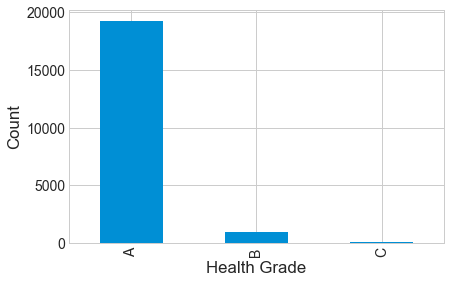

In [66]:
gradeGroup = gradeDF.groupby('grade').grade.count()
gradeGroup.plot(kind='bar')
plt.ylabel("Count")
plt.xlabel("Health Grade")

In [67]:
gradeDF.shape

(20284, 23)

In [68]:
gradeGroup

grade
A    19241
B      947
C       96
Name: grade, dtype: int64

In [69]:
df = gradeDF

In [70]:
df['inspection_date'] = pd.to_datetime(df.inspection_date)

In [71]:
df['inspection_year'] = df.inspection_date.dt.year 

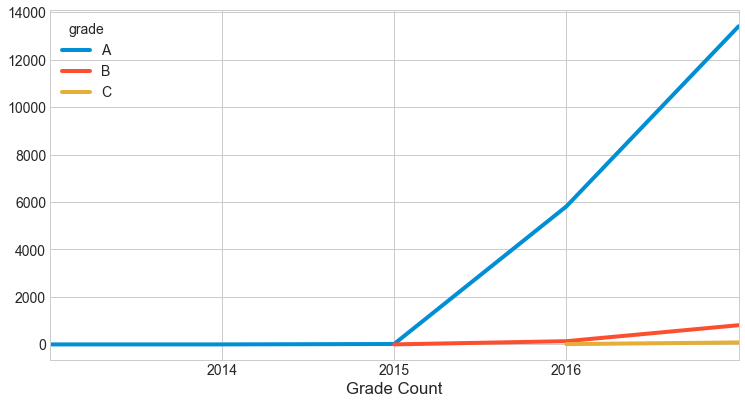

In [72]:
gradeYearGroup = df.groupby(['inspection_year','grade']).camis.count().reset_index()
year_ticks = ('2014','2015','2016')
#entry_ticks = (200,300,400)
plot_out = gradeYearGroup.pivot('inspection_year','grade','camis').plot(kind='line',figsize=(11,6))
plt.xticks(range(2014,2017),year_ticks)
plt.xlabel("Inspection Year")
plt.xlabel("Grade Count")

### Agregate Violations by Restaurant

In [73]:
df.dropna(subset=['dba','zipcode'],inplace=True,axis=0)

In [74]:
df.address.replace("MANHATTAN","NEW YORK",inplace=True)

In [75]:
df.shape

(20284, 24)

In [76]:
df['violation_count'] = 1
restGroup = df.groupby(['dba','address']).violation_count.sum().reset_index()
restGroup.sort_values('violation_count',ascending=False,inplace=True)

In [77]:
#df.to_csv('test.csv')

In [78]:
restGroup.head()

,dba,address,violation_count
0,#1 Chinese Restaurant,825 W 181ST ST MANHATTAN 10033,1
13520,OVERLOOK,225 EAST 44 STREET MANHATTAN 10017,1
13527,OXFORD CAFE,109 EAST 59 STREET MANHATTAN 10022,1
13526,OXFORD BAKE SHOP,10401 LIBERTY AVENUE QUEENS 11417,1
13525,OX VERTE,63 READE ST MANHATTAN 10007,1


In [79]:
restGroup.shape

(20284, 3)

### Prepare to match with Yelp

In [80]:
df.columns.tolist()

['key',
 'violations',
 'critical',
 'camis',
 'dba',
 'boro',
 'building',
 'street',
 'zipcode',
 'phone',
 'cuisine_description',
 'inspection_date',
 'action',
 'violation_code',
 'violation_description',
 'critical_flag',
 'score',
 'grade',
 'grade_date',
 'record_date',
 'inspection_type',
 'address',
 'new_violations',
 'inspection_year',
 'violation_count']

In [81]:
df.head()

,key,violations,critical,camis,dba,boro,building,street,zipcode,phone,...,critical_flag,score,grade,grade_date,record_date,inspection_type,address,new_violations,inspection_year,violation_count
0,#1 Chinese Restaurant---825 W 181ST ST MANHATT...,"06C, 06D, 10F","Critical, Critical, Not Critical",50050805,#1 Chinese Restaurant,MANHATTAN,825,W 181ST ST,10033,9173258805,...,Critical,13.0,A,2016-09-30,2017-08-28,Pre-permit (Operational) / Initial Inspection,825 W 181ST ST MANHATTAN 10033,"contamination, contamination, facility",2016,1
1,#1 GARDEN CHINESE---221 PROSPECT PARK WEST BRO...,"06A, 02G","Critical, Critical",41568346,#1 GARDEN CHINESE,BROOKLYN,221,PROSPECT PARK WEST,11215,7188321795,...,Critical,12.0,A,2017-08-23,2017-08-28,Cycle Inspection / Initial Inspection,221 PROSPECT PARK WEST BROOKLYN 11215,"hygiene, temperature",2017,1
2,#1 Natural Juice Bar---685 SENECA AVE QUEENS 1...,"08A, 04L","Not Critical, Critical",50051964,#1 Natural Juice Bar,QUEENS,685,SENECA AVE,11385,3479565161,...,Not Critical,10.0,A,2017-08-17,2017-08-28,Cycle Inspection / Initial Inspection,685 SENECA AVE QUEENS 11385,"vermin, vermin",2017,1
3,#1 SABOR LATINO RESTAURANT---4120 WHITE PLAINS...,"08A, 04L","Not Critical, Critical",41336841,#1 SABOR LATINO RESTAURANT,BRONX,4120,WHITE PLAINS ROAD,10466,7186532222,...,Not Critical,11.0,A,2017-03-16,2017-08-28,Cycle Inspection / Initial Inspection,4120 WHITE PLAINS ROAD BRONX 10466,"vermin, vermin",2017,1
4,$1 PIZZA---1276 FULTON ST BROOKLYN 11216,"10H, 06E","Not Critical, Critical",50061194,$1 PIZZA,BROOKLYN,1276,FULTON ST,11216,7186384685,...,Not Critical,10.0,A,2017-05-22,2017-08-28,Pre-permit (Operational) / Re-inspection,1276 FULTON ST BROOKLYN 11216,"facility, hygiene",2017,1


In [82]:
uniqueDF = df.copy()

In [83]:
uniqueDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20284 entries, 0 to 25984
Data columns (total 25 columns):
key                      20284 non-null object
violations               20284 non-null object
critical                 20284 non-null object
camis                    20284 non-null int64
dba                      20284 non-null object
boro                     20284 non-null object
building                 20284 non-null object
street                   20284 non-null object
zipcode                  20284 non-null object
phone                    20284 non-null object
cuisine_description      20284 non-null object
inspection_date          20284 non-null datetime64[ns]
action                   20284 non-null object
violation_code           20284 non-null object
violation_description    20254 non-null object
critical_flag            20284 non-null object
score                    20284 non-null float64
grade                    20284 non-null object
grade_date               20284 non-nu

In [84]:
uniqueDF.grade.isnull().sum()

0

In [85]:
uniqueDF.head()

,key,violations,critical,camis,dba,boro,building,street,zipcode,phone,...,critical_flag,score,grade,grade_date,record_date,inspection_type,address,new_violations,inspection_year,violation_count
0,#1 Chinese Restaurant---825 W 181ST ST MANHATT...,"06C, 06D, 10F","Critical, Critical, Not Critical",50050805,#1 Chinese Restaurant,MANHATTAN,825,W 181ST ST,10033,9173258805,...,Critical,13.0,A,2016-09-30,2017-08-28,Pre-permit (Operational) / Initial Inspection,825 W 181ST ST MANHATTAN 10033,"contamination, contamination, facility",2016,1
1,#1 GARDEN CHINESE---221 PROSPECT PARK WEST BRO...,"06A, 02G","Critical, Critical",41568346,#1 GARDEN CHINESE,BROOKLYN,221,PROSPECT PARK WEST,11215,7188321795,...,Critical,12.0,A,2017-08-23,2017-08-28,Cycle Inspection / Initial Inspection,221 PROSPECT PARK WEST BROOKLYN 11215,"hygiene, temperature",2017,1
2,#1 Natural Juice Bar---685 SENECA AVE QUEENS 1...,"08A, 04L","Not Critical, Critical",50051964,#1 Natural Juice Bar,QUEENS,685,SENECA AVE,11385,3479565161,...,Not Critical,10.0,A,2017-08-17,2017-08-28,Cycle Inspection / Initial Inspection,685 SENECA AVE QUEENS 11385,"vermin, vermin",2017,1
3,#1 SABOR LATINO RESTAURANT---4120 WHITE PLAINS...,"08A, 04L","Not Critical, Critical",41336841,#1 SABOR LATINO RESTAURANT,BRONX,4120,WHITE PLAINS ROAD,10466,7186532222,...,Not Critical,11.0,A,2017-03-16,2017-08-28,Cycle Inspection / Initial Inspection,4120 WHITE PLAINS ROAD BRONX 10466,"vermin, vermin",2017,1
4,$1 PIZZA---1276 FULTON ST BROOKLYN 11216,"10H, 06E","Not Critical, Critical",50061194,$1 PIZZA,BROOKLYN,1276,FULTON ST,11216,7186384685,...,Not Critical,10.0,A,2017-05-22,2017-08-28,Pre-permit (Operational) / Re-inspection,1276 FULTON ST BROOKLYN 11216,"facility, hygiene",2017,1


In [86]:
#uniqueDF.shape

In [87]:
#dupes = ['dba','address']

In [88]:
#df2 = uniqueDF.drop_duplicates(subset=dupes,keep='first')

In [89]:
#df2.shape

In [90]:
#df2.head()

In [91]:
#df2.dropna(subset=['address'],inplace=True,axis=0)

In [92]:
#

In [93]:
df.rename(columns={'dba':'name'},inplace=True)

In [94]:
uniqueDF = df.copy()

In [95]:
uniqueDF.grade.isnull().sum()

0

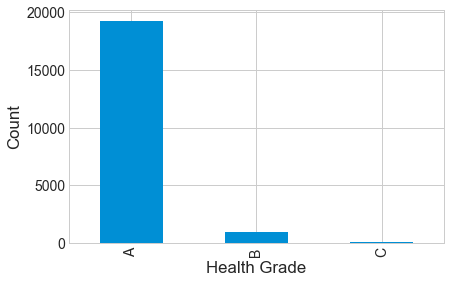

In [96]:
gradeGroup = uniqueDF.groupby('grade').grade.count()
gradeGroup.plot(kind='bar')
plt.ylabel("Count")
plt.xlabel("Health Grade")

In [97]:
uniqueDF.groupby('grade').name.nunique()

grade
A    15395
B      919
C       96
Name: name, dtype: int64

In [98]:
# def replace_cuisine(row,s,r):
# #     

In [99]:
uniqueDF.cuisine_description.replace('CafÃ©/Coffee/Tea','Coffee',inplace=True)

In [100]:
uniqueDF.cuisine_description.replace('Latin (Cuban, Dominican, Puerto Rican, South & Central American)','Latin',inplace=True)

In [101]:
uniqueDF.cuisine_description.replace('Bottled beverages, including water, sodas, juices, etc.','Bottle Beverages',inplace=True)

In [102]:
uniqueDF.cuisine_description.replace('Sandwiches/Salads/Mixed Buffet','Mixed Buffet',inplace=True)

In [103]:
uniqueDF.cuisine_description.replace('Ice Cream, Gelato, Yogurt, Ices','Ice Cream',inplace=True)

In [104]:
uniqueDF.cuisine_description.replace('Soups & Sandwiches','Sandwiches',inplace=True)

In [105]:
cuisineGroup = uniqueDF.groupby('cuisine_description').grade.count().reset_index()
cuisineGroup.sort_values('grade',ascending=False,inplace=True)
cuisineGroup.head()

,cuisine_description,grade
2,American,4876
17,Chinese,1937
20,Coffee,1286
62,Pizza,960
45,Italian,815


In [106]:
cuisineDF = uniqueDF.cuisine_description.str.get_dummies()

In [107]:
cuisineDF.columns.tolist()

['Afghan',
 'African',
 'American',
 'Armenian',
 'Asian',
 'Australian',
 'Bagels/Pretzels',
 'Bakery',
 'Bangladeshi',
 'Barbecue',
 'Bottle Beverages',
 'Brazilian',
 'Cajun',
 'Californian',
 'Caribbean',
 'Chicken',
 'Chilean',
 'Chinese',
 'Chinese/Cuban',
 'Chinese/Japanese',
 'Coffee',
 'Continental',
 'Creole',
 'Creole/Cajun',
 'Czech',
 'Delicatessen',
 'Donuts',
 'Eastern European',
 'Egyptian',
 'English',
 'Ethiopian',
 'Filipino',
 'French',
 'Fruits/Vegetables',
 'German',
 'Greek',
 'Hamburgers',
 'Hawaiian',
 'Hotdogs',
 'Hotdogs/Pretzels',
 'Ice Cream',
 'Indian',
 'Indonesian',
 'Iranian',
 'Irish',
 'Italian',
 'Japanese',
 'Jewish/Kosher',
 'Juice, Smoothies, Fruit Salads',
 'Korean',
 'Latin',
 'Mediterranean',
 'Mexican',
 'Middle Eastern',
 'Mixed Buffet',
 'Moroccan',
 'Not Listed/Not Applicable',
 'Nuts/Confectionary',
 'Other',
 'Pakistani',
 'Pancakes/Waffles',
 'Peruvian',
 'Pizza',
 'Pizza/Italian',
 'Polish',
 'Polynesian',
 'Portuguese',
 'Russian',
 'S

In [108]:
cuisineDF.head()

,Afghan,African,American,Armenian,Asian,Australian,Bagels/Pretzels,Bakery,Bangladeshi,Barbecue,...,Soups,Southwestern,Spanish,Steak,Tapas,Tex-Mex,Thai,Turkish,Vegetarian,Vietnamese/Cambodian/Malaysia
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
uniqueDF = uniqueDF.join(cuisineDF)

In [111]:
uniqueDF.to_pickle('data/inspectionv1.pkl')

In [201]:
uniqueDF = pd.read_pickle('data/inspectionv1.pkl')

In [202]:
uniqueDF['critical'] = [x.strip().replace(' ', '') for x in uniqueDF.critical]

In [203]:
uniqueDF.head()

,key,violations,critical,camis,name,boro,building,street,zipcode,phone,...,Soups,Southwestern,Spanish,Steak,Tapas,Tex-Mex,Thai,Turkish,Vegetarian,Vietnamese/Cambodian/Malaysia
0,#1 Chinese Restaurant---825 W 181ST ST MANHATT...,"06C, 06D, 10F","Critical,Critical,NotCritical",50050805,#1 Chinese Restaurant,MANHATTAN,825,W 181ST ST,10033,9173258805,...,0,0,0,0,0,0,0,0,0,0
1,#1 GARDEN CHINESE---221 PROSPECT PARK WEST BRO...,"06A, 02G","Critical,Critical",41568346,#1 GARDEN CHINESE,BROOKLYN,221,PROSPECT PARK WEST,11215,7188321795,...,0,0,0,0,0,0,0,0,0,0
2,#1 Natural Juice Bar---685 SENECA AVE QUEENS 1...,"08A, 04L","NotCritical,Critical",50051964,#1 Natural Juice Bar,QUEENS,685,SENECA AVE,11385,3479565161,...,0,0,0,0,0,0,0,0,0,0
3,#1 SABOR LATINO RESTAURANT---4120 WHITE PLAINS...,"08A, 04L","NotCritical,Critical",41336841,#1 SABOR LATINO RESTAURANT,BRONX,4120,WHITE PLAINS ROAD,10466,7186532222,...,0,0,0,0,0,0,0,0,0,0
4,$1 PIZZA---1276 FULTON ST BROOKLYN 11216,"10H, 06E","NotCritical,Critical",50061194,$1 PIZZA,BROOKLYN,1276,FULTON ST,11216,7186384685,...,0,0,0,0,0,0,0,0,0,0


In [204]:
from sklearn.feature_extraction.text import CountVectorizer

In [205]:
vectorizer = CountVectorizer()
features = vectorizer.fit_transform(uniqueDF.critical)

In [206]:
vectorizer.get_feature_names()

['critical', 'notapplicable', 'notcritical']

In [207]:
critDF = pd.DataFrame(features.todense(),columns =vectorizer.get_feature_names())

In [208]:
critDF.head()

,critical,notapplicable,notcritical
0,2,0,1
1,2,0,0
2,1,0,1
3,1,0,1
4,1,0,1


In [209]:
critDF.shape

(20284, 3)

In [210]:
uniqueDF.shape

(20284, 108)

In [211]:
uniqueDF.drop('critical',axis=1,inplace=True)

In [212]:
uniqueDF = uniqueDF.join(critDF
             )

In [213]:
uniqueDF.drop('critical_flag',inplace=True, axis=1)

In [214]:
uniqueDF.drop('Other',inplace=True,axis=1)

In [215]:
uniqueDF.drop('cuisine_description',inplace=True, axis=1)

In [216]:
vectorizer2 = CountVectorizer()
features2 = vectorizer2.fit_transform(uniqueDF.new_violations)
vectorizer2.get_feature_names()

['contamination',
 'facility',
 'food_handling',
 'hygiene',
 'regulatory',
 'temperature',
 'vermin']

In [217]:
violationDF = pd.DataFrame(features2.todense(),columns =vectorizer2.get_feature_names())

In [218]:
violationDF.head()

,contamination,facility,food_handling,hygiene,regulatory,temperature,vermin
0,2,1,0,0,0,0,0
1,0,0,0,1,0,1,0
2,0,0,0,0,0,0,2
3,0,0,0,0,0,0,2
4,0,1,0,1,0,0,0


In [219]:
violationDF.shape

(20284, 7)

In [220]:
uniqueDF = uniqueDF.join(violationDF)

In [221]:
uniqueDF.shape

(20284, 114)

In [222]:
restGroup.shape

(20284, 3)

In [223]:
#uniqueDF.drop(['address','violation_count'],axis=1,inplace=True)

In [224]:
uniqueDF.head()

,key,violations,camis,name,boro,building,street,zipcode,phone,inspection_date,...,critical,notapplicable,notcritical,contamination,facility,food_handling,hygiene,regulatory,temperature,vermin
0,#1 Chinese Restaurant---825 W 181ST ST MANHATT...,"06C, 06D, 10F",50050805,#1 Chinese Restaurant,MANHATTAN,825,W 181ST ST,10033,9173258805,2016-09-30,...,2.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
1,#1 GARDEN CHINESE---221 PROSPECT PARK WEST BRO...,"06A, 02G",41568346,#1 GARDEN CHINESE,BROOKLYN,221,PROSPECT PARK WEST,11215,7188321795,2017-08-23,...,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,#1 Natural Juice Bar---685 SENECA AVE QUEENS 1...,"08A, 04L",50051964,#1 Natural Juice Bar,QUEENS,685,SENECA AVE,11385,3479565161,2017-08-17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,#1 SABOR LATINO RESTAURANT---4120 WHITE PLAINS...,"08A, 04L",41336841,#1 SABOR LATINO RESTAURANT,BRONX,4120,WHITE PLAINS ROAD,10466,7186532222,2017-03-16,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,$1 PIZZA---1276 FULTON ST BROOKLYN 11216,"10H, 06E",50061194,$1 PIZZA,BROOKLYN,1276,FULTON ST,11216,7186384685,2017-05-22,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [225]:
#allDF = restGroup.join(uniqueDF,how='left')

In [226]:
#allDF.shape

In [227]:
#allDF.columns.tolist()

In [228]:
#allDF.drop('dba',axis=1,inplace=True)

In [229]:
#allDF.head()

In [230]:
boroDF = uniqueDF.boro.str.get_dummies()

In [231]:
boroDF.columns = map(str.lower, boroDF.columns)

In [232]:
boroDF.drop('staten island',axis=1,inplace=True)

In [233]:
uniqueDF = uniqueDF.join(boroDF)

In [234]:
uniqueDF.drop('boro',axis=1,inplace=True)

In [235]:
uniqueDF.shape

(20284, 117)

In [236]:
#uniqueDF.groupby(['name','inspection_date']).violation_code.count()

In [237]:
#uniqueDF.head()

In [238]:
#testDF = uniqueDF.loc[uniqueDF.groupby(['name','violations'])['inspection_date'].idxmax()]

In [239]:
# testDF.

In [240]:
dfFeatures = ['violation_count' 'zipcode', 'score', 'grade', 'contamination','facility','food_handling','hygiene','temperature','vermin', 'inspection_year', 'Afghan', 'African', 'American', 'Armenian', 'Asian', 'Australian', 'Bagels/Pretzels', 'Bakery', 'Bangladeshi', 'Barbecue', 'Bottle Beverages', 'Brazilian', 'Cajun', 'Californian', 'Caribbean', 'Chicken', 'Chilean', 'Chinese', 'Chinese/Cuban', 'Chinese/Japanese', 'Coffee', 'Continental', 'Creole', 'Creole/Cajun', 'Czech', 'Delicatessen', 'Donuts', 'Eastern European', 'Egyptian', 'English', 'Ethiopian', 'Filipino', 'French', 'Fruits/Vegetables', 'German', 'Greek', 'Hamburgers', 'Hawaiian', 'Hotdogs', 'Hotdogs/Pretzels', 'Ice Cream', 'Indian', 'Indonesian', 'Iranian', 'Irish', 'Italian', 'Japanese', 'Jewish/Kosher', 'Juice, Smoothies, Fruit Salads', 'Korean', 'Latin', 'Mediterranean', 'Mexican', 'Middle Eastern', 'Mixed Buffet', 'Moroccan', 'Not Listed/Not Applicable', 'Nuts/Confectionary', 'Pakistani', 'Pancakes/Waffles', 'Peruvian', 'Pizza', 'Pizza/Italian', 'Polish', 'Polynesian', 'Portuguese', 'Russian', 'Salads', 'Sandwiches', 'Scandinavian', 'Seafood', 'Soul Food', 'Soups', 'Southwestern', 'Spanish', 'Steak', 'Tapas', 'Tex-Mex', 'Thai', 'Turkish', 'Vegetarian', 'Vietnamese/Cambodian/Malaysia', 'bronx', 'brooklyn', 'manhattan', 'queens','match']

In [241]:
to_drop = ['key','violations','camis','building','street','phone','action',
 'violation_description','violation_code','grade_date','record_date','inspection_type',
           'new_violations','inspection_date']

In [242]:
uniqueDF.columns.tolist()

['key',
 'violations',
 'camis',
 'name',
 'building',
 'street',
 'zipcode',
 'phone',
 'inspection_date',
 'action',
 'violation_code',
 'violation_description',
 'score',
 'grade',
 'grade_date',
 'record_date',
 'inspection_type',
 'address',
 'new_violations',
 'inspection_year',
 'violation_count',
 'Afghan',
 'African',
 'American',
 'Armenian',
 'Asian',
 'Australian',
 'Bagels/Pretzels',
 'Bakery',
 'Bangladeshi',
 'Barbecue',
 'Bottle Beverages',
 'Brazilian',
 'Cajun',
 'Californian',
 'Caribbean',
 'Chicken',
 'Chilean',
 'Chinese',
 'Chinese/Cuban',
 'Chinese/Japanese',
 'Coffee',
 'Continental',
 'Creole',
 'Creole/Cajun',
 'Czech',
 'Delicatessen',
 'Donuts',
 'Eastern European',
 'Egyptian',
 'English',
 'Ethiopian',
 'Filipino',
 'French',
 'Fruits/Vegetables',
 'German',
 'Greek',
 'Hamburgers',
 'Hawaiian',
 'Hotdogs',
 'Hotdogs/Pretzels',
 'Ice Cream',
 'Indian',
 'Indonesian',
 'Iranian',
 'Irish',
 'Italian',
 'Japanese',
 'Jewish/Kosher',
 'Juice, Smoothies, Frui

In [243]:
sumList = ['contamination','facility','food_handling','hygiene','regulatory','temperature','vermin']


In [244]:
uniqueDF['violation_count'] = uniqueDF[sumList].sum(axis=1).astype(int)

In [245]:
uniqueDF.drop(to_drop,axis=1,inplace=True)

In [246]:
uniqueDF.shape

(20284, 103)

In [247]:
uniqueDF.columns.tolist()

['name',
 'zipcode',
 'score',
 'grade',
 'address',
 'inspection_year',
 'violation_count',
 'Afghan',
 'African',
 'American',
 'Armenian',
 'Asian',
 'Australian',
 'Bagels/Pretzels',
 'Bakery',
 'Bangladeshi',
 'Barbecue',
 'Bottle Beverages',
 'Brazilian',
 'Cajun',
 'Californian',
 'Caribbean',
 'Chicken',
 'Chilean',
 'Chinese',
 'Chinese/Cuban',
 'Chinese/Japanese',
 'Coffee',
 'Continental',
 'Creole',
 'Creole/Cajun',
 'Czech',
 'Delicatessen',
 'Donuts',
 'Eastern European',
 'Egyptian',
 'English',
 'Ethiopian',
 'Filipino',
 'French',
 'Fruits/Vegetables',
 'German',
 'Greek',
 'Hamburgers',
 'Hawaiian',
 'Hotdogs',
 'Hotdogs/Pretzels',
 'Ice Cream',
 'Indian',
 'Indonesian',
 'Iranian',
 'Irish',
 'Italian',
 'Japanese',
 'Jewish/Kosher',
 'Juice, Smoothies, Fruit Salads',
 'Korean',
 'Latin',
 'Mediterranean',
 'Mexican',
 'Middle Eastern',
 'Mixed Buffet',
 'Moroccan',
 'Not Listed/Not Applicable',
 'Nuts/Confectionary',
 'Pakistani',
 'Pancakes/Waffles',
 'Peruvian',
 

In [248]:
uniqueDF.to_pickle('data/clean.pkl')

## Yelp Data

In [179]:
data = []
with open('data/yelp_restaurants.json') as f:
    for line in f:
        data.append(json.loads(line))
    
yelpDF = pd.io.json.json_normalize(data)

In [180]:
yelpDF.head()

,business_id,business_name,categories,coordinates.latitude,coordinates.longitude,is_closed,location.address1,location.address2,location.address3,location.city,location.country,location.display_address,location.state,location.zip_code,price,rating,review_count
0,notaro-ristorante-new-york-2,Notaro Ristorante,"[{'alias': 'italian', 'title': 'Italian'}]",40.745323,-73.975845,False,635 2nd Ave,,,New York,US,"[635 2nd Ave, New York, NY 10016]",NY,10016,$$,3.0,90
1,vite-bar-astoria,Vite Bar,"[{'alias': 'italian', 'title': 'Italian'}, {'a...",40.763414,-73.928119,False,2507 Broadway,,,Astoria,US,"[2507 Broadway, Astoria, NY 11106]",NY,11106,$$,4.5,76
2,tacks-chinese-take-out-staten-island,Tack's Chinese Take Out,"[{'alias': 'chinese', 'title': 'Chinese'}]",40.604620,-74.121230,False,11C Holden Blvd,,,Staten Island,US,"[11C Holden Blvd, Staten Island, NY 10314]",NY,10314,$$,4.0,52
3,no-quarter-brooklyn,No Quarter,"[{'alias': 'lounges', 'title': 'Lounges'}]",40.625198,-74.024025,False,8015 5th Ave,,,Brooklyn,US,"[8015 5th Ave, Brooklyn, NY 11209]",NY,11209,$,2.5,16
4,henris-backyard-brooklyn,HENRI's Backyard,"[{'alias': 'beerbar', 'title': 'Beer Bar'}, {'...",40.676470,-73.983940,True,256 4th Ave,None,,Brooklyn,US,"[256 4th Ave, Brooklyn, NY 11215]",NY,11215,$$,4.0,15


In [181]:
yelpDF.shape

(23397, 17)

In [182]:
yelpDF['clean_address'] = yelpDF['location.display_address'].apply(lambda x: ', '.join(x))

In [183]:
yelpDF.drop('location.display_address',axis=1,inplace=True)

In [184]:
def convert_categoies(row):
    cats = ''
    for dic in row['categories']:
        for key in dic:
            if key == 'alias':
                cats += dic[key]+','
            else:
                next
    return cats[:-1]

In [185]:
yelpDF['categories_clean'] = yelpDF.apply(lambda row: convert_categoies(row),axis=1)

In [186]:
yelpDF.head()

,business_id,business_name,categories,coordinates.latitude,coordinates.longitude,is_closed,location.address1,location.address2,location.address3,location.city,location.country,location.state,location.zip_code,price,rating,review_count,clean_address,categories_clean
0,notaro-ristorante-new-york-2,Notaro Ristorante,"[{'alias': 'italian', 'title': 'Italian'}]",40.745323,-73.975845,False,635 2nd Ave,,,New York,US,NY,10016,$$,3.0,90,"635 2nd Ave, New York, NY 10016",italian
1,vite-bar-astoria,Vite Bar,"[{'alias': 'italian', 'title': 'Italian'}, {'a...",40.763414,-73.928119,False,2507 Broadway,,,Astoria,US,NY,11106,$$,4.5,76,"2507 Broadway, Astoria, NY 11106","italian,tapas"
2,tacks-chinese-take-out-staten-island,Tack's Chinese Take Out,"[{'alias': 'chinese', 'title': 'Chinese'}]",40.604620,-74.121230,False,11C Holden Blvd,,,Staten Island,US,NY,10314,$$,4.0,52,"11C Holden Blvd, Staten Island, NY 10314",chinese
3,no-quarter-brooklyn,No Quarter,"[{'alias': 'lounges', 'title': 'Lounges'}]",40.625198,-74.024025,False,8015 5th Ave,,,Brooklyn,US,NY,11209,$,2.5,16,"8015 5th Ave, Brooklyn, NY 11209",lounges
4,henris-backyard-brooklyn,HENRI's Backyard,"[{'alias': 'beerbar', 'title': 'Beer Bar'}, {'...",40.676470,-73.983940,True,256 4th Ave,None,,Brooklyn,US,NY,11215,$$,4.0,15,"256 4th Ave, Brooklyn, NY 11215","beerbar,newamerican,vegan"


In [187]:
yelpDF.drop('categories',axis=1,inplace=True)

In [188]:
yelpDF.head()

,business_id,business_name,coordinates.latitude,coordinates.longitude,is_closed,location.address1,location.address2,location.address3,location.city,location.country,location.state,location.zip_code,price,rating,review_count,clean_address,categories_clean
0,notaro-ristorante-new-york-2,Notaro Ristorante,40.745323,-73.975845,False,635 2nd Ave,,,New York,US,NY,10016,$$,3.0,90,"635 2nd Ave, New York, NY 10016",italian
1,vite-bar-astoria,Vite Bar,40.763414,-73.928119,False,2507 Broadway,,,Astoria,US,NY,11106,$$,4.5,76,"2507 Broadway, Astoria, NY 11106","italian,tapas"
2,tacks-chinese-take-out-staten-island,Tack's Chinese Take Out,40.604620,-74.121230,False,11C Holden Blvd,,,Staten Island,US,NY,10314,$$,4.0,52,"11C Holden Blvd, Staten Island, NY 10314",chinese
3,no-quarter-brooklyn,No Quarter,40.625198,-74.024025,False,8015 5th Ave,,,Brooklyn,US,NY,11209,$,2.5,16,"8015 5th Ave, Brooklyn, NY 11209",lounges
4,henris-backyard-brooklyn,HENRI's Backyard,40.676470,-73.983940,True,256 4th Ave,None,,Brooklyn,US,NY,11215,$$,4.0,15,"256 4th Ave, Brooklyn, NY 11215","beerbar,newamerican,vegan"


In [189]:
def return_dummies(col):
    return col.str.get_dummies(sep=',')
    

In [190]:
catDF = return_dummies(yelpDF.categories_clean)

In [191]:
priceDF = return_dummies(yelpDF.price)

In [192]:
catDF.shape

(23397, 396)

In [193]:
yelpDF.price.unique()

array(['$$', '$', '$$$', '$$$$'], dtype=object)

In [194]:
priceDF = priceDF[priceDF.columns.tolist()[0:-1]]

In [195]:
catDF = catDF[catDF.columns.tolist()[0:-1]]

In [196]:
yelpDF = yelpDF.join(priceDF)

In [197]:
yelpDF.drop(['categories_clean','price'],inplace=True,axis=1)

In [198]:
yelpDF.head()

,business_id,business_name,coordinates.latitude,coordinates.longitude,is_closed,location.address1,location.address2,location.address3,location.city,location.country,location.state,location.zip_code,rating,review_count,clean_address,$,$$,$$$
0,notaro-ristorante-new-york-2,Notaro Ristorante,40.745323,-73.975845,False,635 2nd Ave,,,New York,US,NY,10016,3.0,90,"635 2nd Ave, New York, NY 10016",0,1,0
1,vite-bar-astoria,Vite Bar,40.763414,-73.928119,False,2507 Broadway,,,Astoria,US,NY,11106,4.5,76,"2507 Broadway, Astoria, NY 11106",0,1,0
2,tacks-chinese-take-out-staten-island,Tack's Chinese Take Out,40.604620,-74.121230,False,11C Holden Blvd,,,Staten Island,US,NY,10314,4.0,52,"11C Holden Blvd, Staten Island, NY 10314",0,1,0
3,no-quarter-brooklyn,No Quarter,40.625198,-74.024025,False,8015 5th Ave,,,Brooklyn,US,NY,11209,2.5,16,"8015 5th Ave, Brooklyn, NY 11209",1,0,0
4,henris-backyard-brooklyn,HENRI's Backyard,40.676470,-73.983940,True,256 4th Ave,None,,Brooklyn,US,NY,11215,4.0,15,"256 4th Ave, Brooklyn, NY 11215",0,1,0


In [199]:
yelpDF.shape

(23397, 18)

In [200]:
yelpDF.head()

,business_id,business_name,coordinates.latitude,coordinates.longitude,is_closed,location.address1,location.address2,location.address3,location.city,location.country,location.state,location.zip_code,rating,review_count,clean_address,$,$$,$$$
0,notaro-ristorante-new-york-2,Notaro Ristorante,40.745323,-73.975845,False,635 2nd Ave,,,New York,US,NY,10016,3.0,90,"635 2nd Ave, New York, NY 10016",0,1,0
1,vite-bar-astoria,Vite Bar,40.763414,-73.928119,False,2507 Broadway,,,Astoria,US,NY,11106,4.5,76,"2507 Broadway, Astoria, NY 11106",0,1,0
2,tacks-chinese-take-out-staten-island,Tack's Chinese Take Out,40.604620,-74.121230,False,11C Holden Blvd,,,Staten Island,US,NY,10314,4.0,52,"11C Holden Blvd, Staten Island, NY 10314",0,1,0
3,no-quarter-brooklyn,No Quarter,40.625198,-74.024025,False,8015 5th Ave,,,Brooklyn,US,NY,11209,2.5,16,"8015 5th Ave, Brooklyn, NY 11209",1,0,0
4,henris-backyard-brooklyn,HENRI's Backyard,40.676470,-73.983940,True,256 4th Ave,None,,Brooklyn,US,NY,11215,4.0,15,"256 4th Ave, Brooklyn, NY 11215",0,1,0


In [249]:
yelpDF['match'] = yelpDF['business_name'] +';'+ yelpDF['clean_address']

Remove columns without grade

In [250]:
#uniqueDF = uniqueDF.dropna(subset=['grade'],axis=0)

In [251]:
uniqueDF['match'] = uniqueDF['name'] +';'+uniqueDF['address']

In [252]:
yelpDF.head()

,business_id,business_name,coordinates.latitude,coordinates.longitude,is_closed,location.address1,location.address2,location.address3,location.city,location.country,location.state,location.zip_code,rating,review_count,clean_address,$,$$,$$$,match
0,notaro-ristorante-new-york-2,Notaro Ristorante,40.745323,-73.975845,False,635 2nd Ave,,,New York,US,NY,10016,3.0,90,"635 2nd Ave, New York, NY 10016",0,1,0,"Notaro Ristorante;635 2nd Ave, New York, NY 10016"
1,vite-bar-astoria,Vite Bar,40.763414,-73.928119,False,2507 Broadway,,,Astoria,US,NY,11106,4.5,76,"2507 Broadway, Astoria, NY 11106",0,1,0,"Vite Bar;2507 Broadway, Astoria, NY 11106"
2,tacks-chinese-take-out-staten-island,Tack's Chinese Take Out,40.604620,-74.121230,False,11C Holden Blvd,,,Staten Island,US,NY,10314,4.0,52,"11C Holden Blvd, Staten Island, NY 10314",0,1,0,"Tack's Chinese Take Out;11C Holden Blvd, State..."
3,no-quarter-brooklyn,No Quarter,40.625198,-74.024025,False,8015 5th Ave,,,Brooklyn,US,NY,11209,2.5,16,"8015 5th Ave, Brooklyn, NY 11209",1,0,0,"No Quarter;8015 5th Ave, Brooklyn, NY 11209"
4,henris-backyard-brooklyn,HENRI's Backyard,40.676470,-73.983940,True,256 4th Ave,None,,Brooklyn,US,NY,11215,4.0,15,"256 4th Ave, Brooklyn, NY 11215",0,1,0,"HENRI's Backyard;256 4th Ave, Brooklyn, NY 11215"


In [253]:
uniqueDF.head()

,name,zipcode,score,grade,address,inspection_year,violation_count,Afghan,African,American,...,food_handling,hygiene,regulatory,temperature,vermin,bronx,brooklyn,manhattan,queens,match
0,#1 Chinese Restaurant,10033,13.0,A,825 W 181ST ST MANHATTAN 10033,2016,3,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,#1 Chinese Restaurant;825 W 181ST ST MANHATTAN...
1,#1 GARDEN CHINESE,11215,12.0,A,221 PROSPECT PARK WEST BROOKLYN 11215,2017,2,0,0,0,...,0.0,1.0,0.0,1.0,0.0,0,1,0,0,#1 GARDEN CHINESE;221 PROSPECT PARK WEST BROOK...
2,#1 Natural Juice Bar,11385,10.0,A,685 SENECA AVE QUEENS 11385,2017,2,0,0,0,...,0.0,0.0,0.0,0.0,2.0,0,0,0,1,#1 Natural Juice Bar;685 SENECA AVE QUEENS 11385
3,#1 SABOR LATINO RESTAURANT,10466,11.0,A,4120 WHITE PLAINS ROAD BRONX 10466,2017,2,0,0,0,...,0.0,0.0,0.0,0.0,2.0,1,0,0,0,#1 SABOR LATINO RESTAURANT;4120 WHITE PLAINS R...
4,$1 PIZZA,11216,10.0,A,1276 FULTON ST BROOKLYN 11216,2017,2,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0,1,0,0,$1 PIZZA;1276 FULTON ST BROOKLYN 11216


In [254]:
# a = df2.title.map(lambda x: difflib.get_close_matches(x, box2.name))
# df2['merge']= [e[0] if e else '' for e in a]
# boxdf = pd.merge(left=df2,left_on='merge', right=box2,right_on='name')

Test Merge Data (first 100 for each data frame)

In [255]:
# yelpTest = yelpDF.head(100)

In [256]:
# yelpTest['business_name'] = yelpTest.business_name.str.lower()
# yelpTest['match'] = yelpTest.match.str.lower()

In [257]:
# nycTest = uniqueDF.head(100)

In [258]:
# nycTest['match'] = nycTest.match.str.lower()

In [259]:
# a = yelpTest.match.map(lambda x: difflib.get_close_matches(x, nycTest.match,cutoff=.7,))

In [260]:
# yelpTest['merge'] = [e[0] if e else '' for e in a]

In [261]:
#yelpTest.head(50)

In [262]:
yelpDF['match'] = yelpDF.match.str.lower()
uniqueDF['match'] = uniqueDF.match.str.lower()

In [126]:
# a = yelpDF.match.map(lambda x: difflib.get_close_matches(x, uniqueDF.match))

In [131]:
# yelpDF['merge'] = [e[0] if e else '' for e in a]

In [132]:
# yelpDF.head(5)

In [133]:
#mergeDF = yelpTest.merge(nycTest,left_on='merge',right_on='match')

In [135]:
#mergeDF.to_csv('merge.csv')

In [136]:
#uniqueDF = pd.read_pickle('data/inspection.pkl')

### Pickle Merge Ready Inspection Data

In [263]:
uniqueDF.to_pickle('data/nyc_to_merge.pkl')

In [264]:
yelpDF.to_pickle('data/yelp_to_merge.pkl')

### Merge Yelp with NYC Inspection Data

In [154]:
yelpDF = pd.read_csv('data/yelp_merge.csv')

In [155]:
yelpDF.shape

(23397, 21)

In [156]:
uniqueDF.shape

(22316, 111)

In [157]:
yelpDF.columns.tolist()

['index',
 'business_id',
 'business_name',
 'coordinates.latitude',
 'coordinates.longitude',
 'is_closed',
 'location.address1',
 'location.address2',
 'location.address3',
 'location.city',
 'location.country',
 'location.state',
 'location.zip_code',
 'rating',
 'review_count',
 'clean_address',
 '$',
 '$$',
 '$$$',
 'match',
 'merge']

In [158]:
yelpFeatures = ['business_id', 'is_closed', 'rating', 'review_count', '$', '$$', '$$$', 'merge']

In [159]:
yelpDF = yelpDF[yelpFeatures]

In [160]:
uniqueDF = uniqueDF[dfFeatures]

In [161]:
mergeDF = uniqueDF.merge(yelpDF,left_on='match',right_on='merge')

In [162]:
uniqueDF.columns.tolist()

['zipcode',
 'score',
 'grade',
 'contamination',
 'facility',
 'food_handling',
 'hygiene',
 'temperature',
 'vermin',
 'inspection_year',
 'Afghan',
 'African',
 'American',
 'Armenian',
 'Asian',
 'Australian',
 'Bagels/Pretzels',
 'Bakery',
 'Bangladeshi',
 'Barbecue',
 'Bottle Beverages',
 'Brazilian',
 'Cajun',
 'Californian',
 'Caribbean',
 'Chicken',
 'Chilean',
 'Chinese',
 'Chinese/Cuban',
 'Chinese/Japanese',
 'Coffee',
 'Continental',
 'Creole',
 'Creole/Cajun',
 'Czech',
 'Delicatessen',
 'Donuts',
 'Eastern European',
 'Egyptian',
 'English',
 'Ethiopian',
 'Filipino',
 'French',
 'Fruits/Vegetables',
 'German',
 'Greek',
 'Hamburgers',
 'Hawaiian',
 'Hotdogs',
 'Hotdogs/Pretzels',
 'Ice Cream',
 'Indian',
 'Indonesian',
 'Iranian',
 'Irish',
 'Italian',
 'Japanese',
 'Jewish/Kosher',
 'Juice, Smoothies, Fruit Salads',
 'Korean',
 'Latin',
 'Mediterranean',
 'Mexican',
 'Middle Eastern',
 'Mixed Buffet',
 'Moroccan',
 'Not Listed/Not Applicable',
 'Nuts/Confectionary',
 '

In [163]:
mergeDF.shape

(12150, 105)

In [164]:
uniqueDF.drop('match',inplace=True,axis=1)

In [165]:
mergeDF.drop(['merge','match'],axis=1,inplace=True)

In [166]:
mergeDF.to_pickle('data/merge.pkl')

In [167]:
uniqueDF.to_pickle('data/inspection.pkl')